# Support Vector Regression: Sine Data Set

In [1]:
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from scipy.optimize import minimize
import numpy as np

## Generate Sine Data Set

In [2]:
np.random.seed(0)
x = np.linspace(0,24,200).reshape(-1,1)
y = np.sin(x) + 0.25*(np.random.randn(x.size,1))

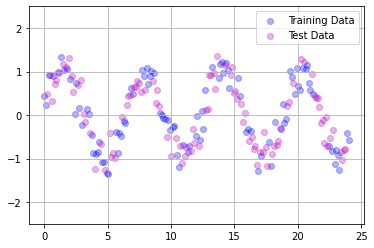

In [3]:
# Option 1: Random 100 for training, random 100 for testing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0)

# Option 2: First 100 for training, next 100 for testing
#X_train, X_test, y_train, y_test = x[:100], x[100:], y[:100], y[100:]

# Option 3: First 50 and last 50 for training, middle 100 for testing
#X_train, X_test, y_train, y_test = np.concatenate([x[:50], x[150:]]),x[50:150],\
#                                   np.concatenate([y[:50], y[150:]]),y[50:150]


def plotData(X_train,X_test,y_train,y_test):
    plt.scatter(X_train,y_train,color='b',alpha=0.3,label='Training Data')
    plt.scatter(X_test,y_test,color='m',alpha=0.3,label='Test Data')
    plt.ylim([-2.5, 2.5])
    plt.grid()
    
plotData(X_train, X_test, y_train, y_test)
plt.legend()
plt.show()

## Create SVR Class

In [4]:
class SupportVecRegression:
    def __init__(self, C=10, eps=0.1, gamma=1):
        self.C = C           # Box constraint
        self.gamma = gamma   # RBF kernel scale
        self.eps = eps       # epsilon
        self.X = None  # Training set X
        self.y = None  # Training set y
        self.b = 0     # Bias

    def kernel_func(self, x1, x2):
        return np.exp(-self.gamma * pairwise_distances(x1, x2, metric='sqeuclidean'))
        
    def fit(self, X, y):        
        self.X, self.y = X, y
        
        # Create kernel (Gram) matrix
        self.K = self.kernel_func(self.X, self.X)

        # Define the objective function for the dual problem
        def objective(alpha):
            # Dual objective
            return 0.5 * np.dot(alpha, np.dot(self.K, alpha)) + self.eps * \
                    np.sum(np.abs(alpha)) - np.dot(self.y.T, alpha)

        # Initial guess for alpha
        initial_alpha = np.zeros(len(X))
        
        # Define the constraints and bounds
        cons = ({'type': 'eq', 'fun': lambda alpha: np.sum(alpha)})
        bnds = [(-self.C, self.C) for _ in initial_alpha]

        # Minimize the objective function subject to the constraints
        res = minimize(objective, initial_alpha, constraints=cons, 
                       bounds=bnds, method='SLSQP')
        print(res.message)

        # Extract the optimal alpha values
        alpha = res.x

        # Extract support vectors
        self.sv_indices = np.abs(alpha) > 1e-5
        self.support_vectors = self.X[self.sv_indices,:]
        self.support_labels = self.y[self.sv_indices]
        self.alpha = alpha[self.sv_indices]
        print(np.where(self.sv_indices))

        # Calculate the bias
        y_pred = self.predict(self.support_vectors)
        self.b = np.mean(self.support_labels - self.eps - y_pred)

    def predict(self, X):
        K = self.kernel_func(self.support_vectors, X)
        return np.dot(self.alpha, K) + self.b

## Train and evaluate SVR model

Optimization terminated successfully
(array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=int64),)
Bias: -0.0670910686833397
No. of support vectors: 98 out of 100
Training MSE: 110.03716621852104
Testing MSE: 102.58261353547958


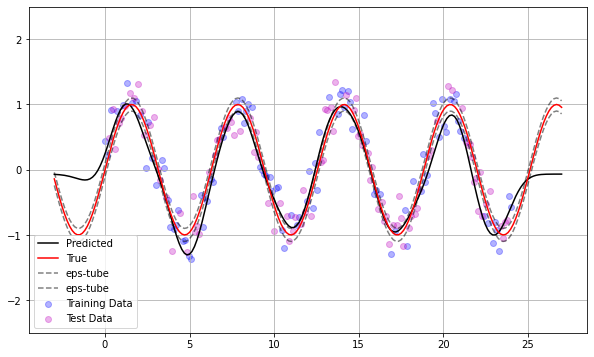

In [5]:
# Train the SVR
C, eps, gamma = 1, 0.1, 0.5
svr = SupportVecRegression(C=C, eps=eps, gamma=gamma)
svr.fit(X_train, y_train)

print(f"Bias: {svr.b}")
print(f"No. of support vectors: {len(svr.alpha)} out of {len(svr.X)}")
    
# Make predictions
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)

# Evaluate accuracy
train_mse = np.sum((y_train_pred - y_train) ** 2) / len(y_train)
test_mse = np.sum((y_test_pred - y_test) ** 2) / len(y_test)
print("Training MSE:", train_mse)
print("Testing MSE:", test_mse)

# Plot the results
x_fine = np.linspace(-3,27,200)
y_pred = np.zeros(x_fine.shape)
y_true = np.sin(x_fine)
for i in range(len(x_fine)):
    y_pred[i] = svr.predict(x_fine[i].reshape(1,-1))

plt.figure(figsize=(10,6))
plotData(X_train, X_test, y_train, y_test)
plt.plot(x_fine,y_pred,c='k',label='Predicted')
plt.plot(x_fine,y_true,c='r',label='True')
plt.plot(x_fine,y_true + eps, 'k--', alpha=0.5, label='eps-tube')
plt.plot(x_fine,y_true - eps, 'k--', alpha=0.5, label='eps-tube')
plt.legend()
plt.show()

## Results using the built-in SVR from sklearn

No. of support vectors: [77] out of 100
Training MSE: 109.16918557399909
Testing MSE: 101.89083173072731


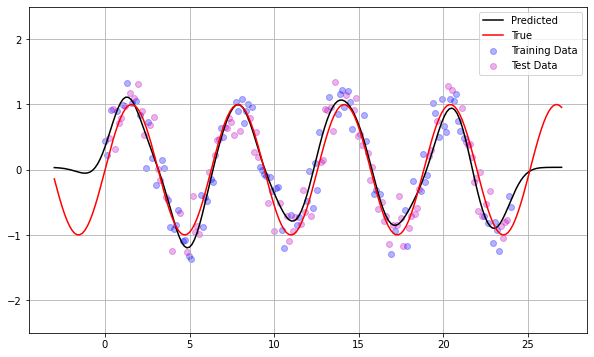

In [6]:
from sklearn.svm import SVR

mdl = SVR(C=1, epsilon=0.1, gamma=0.5).fit(X_train, y_train.ravel())

#print("Indicies of support vectors:")
#print(mdl.support_)
#print("Dual variables (alpha):")
#print(mdl.dual_coef_.reshape(-1,1))
#print("Bias: ")
#print(mdl.intercept_)

print(f"No. of support vectors: {mdl.n_support_} out of {len(X_train)}")

# Make predictions
y_train_pred = mdl.predict(X_train)
y_test_pred = mdl.predict(X_test)

# Evaluate accuracy
train_mse = np.sum((y_train_pred - y_train) ** 2) / len(y_train)
test_mse = np.sum((y_test_pred - y_test) ** 2) / len(y_test)
print("Training MSE:", train_mse)
print("Testing MSE:", test_mse)

# Plot the results
x_fine = np.linspace(-3,27,200)
y_pred = np.zeros(x_fine.shape)
y_true = np.sin(x_fine)
for i in range(len(x_fine)):
    y_pred[i] = mdl.predict(x_fine[i].reshape(1,-1))

plt.figure(figsize=(10,6))
plotData(X_train, X_test, y_train, y_test)
plt.plot(x_fine,y_pred,c='k',label='Predicted')
plt.plot(x_fine,y_true,c='r',label='True')
plt.legend()
plt.show()